In [235]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [236]:
import numpy as np
import pandas as pd

In [237]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [238]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [239]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [240]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [241]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [242]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [243]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [1]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

In [244]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [245]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [246]:
# Calculate the date 1 year ago from the last data point in the database
max_date = engine.execute('SELECT max(date) FROM measurement').fetchall()
print(max_date)

[('2017-08-23',)]


In [247]:
data = engine.execute('SELECT date, prcp FROM measurement WHERE date >= \'2016-08-23\' ORDER BY date').fetchall()

In [248]:
df = pd.DataFrame(data, columns = ['date','precipitation']) 
df.set_index('date')
df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [249]:
# Perform a query to retrieve the data and precipitation scores
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


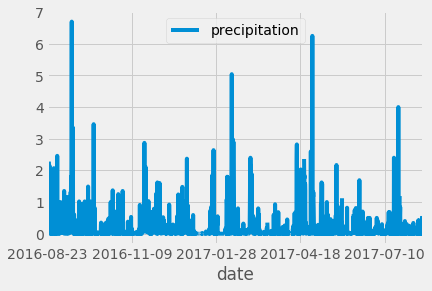

In [250]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
df.plot(x='date', y='precipitation')  

In [251]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [252]:
# Design a query to show how many stations are available in this dataset? [(9])]
engine.execute('SELECT COUNT(DISTINCT(station)) FROM station').fetchall()

[(9,)]

In [355]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute('SELECT station, COUNT(station) FROM measurement GROUP BY station ORDER BY count(station) DESC').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [356]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
engine.execute('SELECT min(tobs), max(tobs), avg(tobs) FROM measurement WHERE station = \'USC00519281\'').fetchall()

[(54.0, 85.0, 71.66378066378067)]

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [357]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
data2 = engine.execute('SELECT tobs FROM measurement WHERE station = \'USC00519281\' AND date >= \'2016-08-23\' ORDER BY date').fetchall()
df = pd.DataFrame(data2, columns = ['tobs']) 
df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


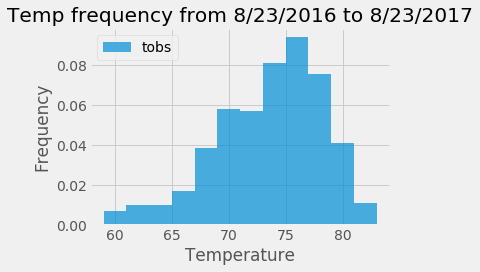

In [351]:
# Plot the results as a histogram

# select data and designate the number of bins
x = df.tobs
num_bins = 12

# the histogram of the data
fig, ax = plt.subplots()
n, bins, patches = ax.hist(x, num_bins, alpha=0.7, density=1)

# lables, title and legend
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temp frequency from 8/23/2016 to 8/23/2017')
ax.legend()

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [298]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [359]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min_avg_max = calc_temps('2016-12-23', '2016-12-30')
print(min_avg_max)

[(65.0, 72.05882352941177, 78.0)]


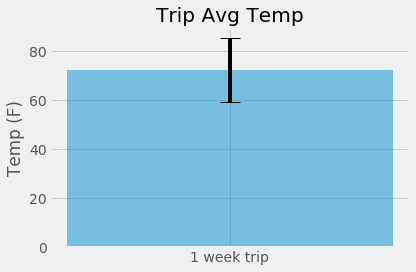

In [360]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Define labels, positions, bar heights and error bar heights
label = ['1 week trip']
x_pos = np.arange(len(label))
mean = [72.05882352941177]
error = [78.0-65.0]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos,
       mean,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Temp (F)')
ax.set_xticks(x_pos)
ax.set_xticklabels(label)
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [361]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

engine.execute('SELECT round(sum(m.prcp),2), s.station, s.name, \
               round(s.latitude,4), round(s.longitude,4), round(s.elevation,1) \
               FROM station as s \
               JOIN measurement as m on s.station = m.station \
               WHERE m.date >= \'2016-12-23\' AND m.date <= \'2016-12-30\' \
               GROUP BY s.station \
               ORDER BY sum(m.prcp) DESC').fetchall()


[(7.45, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (1.63, 'USC00519281', 'WAIHEE 837.5, HI US', 21.4517, -157.8489, 32.9),
 (1.04, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (1.04, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (0.32, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.3356, -157.7114, 19.5),
 (0.22, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [362]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

[(61.0, 70.34693877551021, 78.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


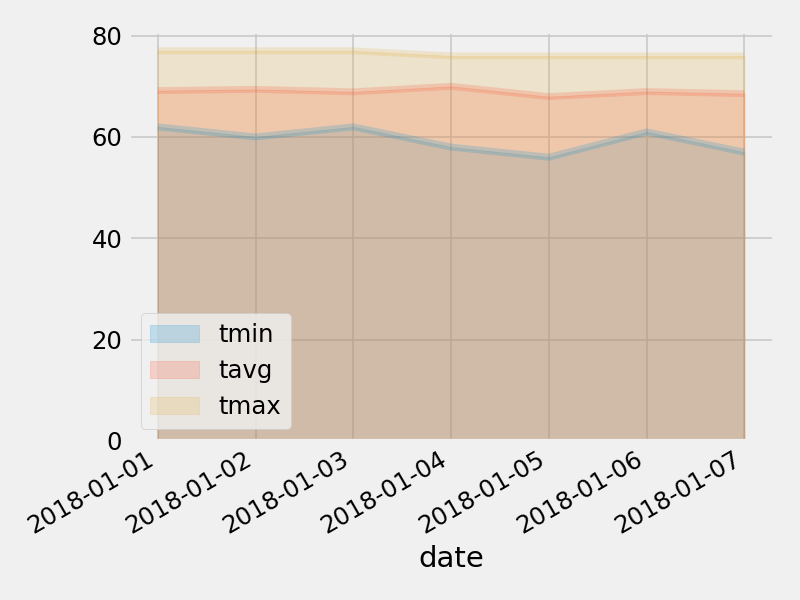

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
